<a href="https://colab.research.google.com/github/anelglvz/Deep_Learning/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

from skimage.morphology import label

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

### Data

Info de los datos en: https://www.kaggle.com/competitions/airbus-ship-detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!unzip '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/sampleDir2.zip'

In [4]:
!unzip '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/train_ship_segmentations_v2.csv.zip'

Archive:  /content/drive/MyDrive/Curso-Deep-Learning/U-Net/train_ship_segmentations_v2.csv.zip
  inflating: train_ship_segmentations_v2.csv  


In [5]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
print(df.shape)
df

(231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [6]:
print(df.shape[0], 'masks found')
print(len(df['ImageId'].unique()), 'unique images found')

231723 masks found
192556 unique images found


In [7]:
df[df['ImageId'] == '0005d01c8.jpg']

,ImageId,EncodedPixels
29,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30,0005d01c8.jpg,365871 1 366638 3 367405 6 368173 7 368940 9 3...


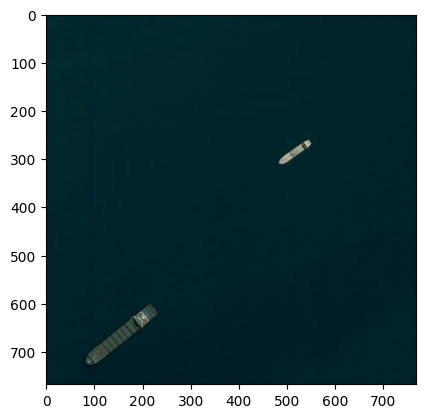

In [8]:
aux = Image.open('/content/train_v2_2/0005d01c8.jpg')
new_image = aux.resize((100, 100))
plt.imshow(aux)
#plt.imshow(new_image)
plt.show()

In [9]:
images = np.array(os.listdir('/content/train_v2_2'))
len(images)

17927

In [10]:
marks = df[df['ImageId'].isin(images)]
marks

,ImageId,EncodedPixels
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
10,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
11,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
12,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
13,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
...,...,...
231671,ffef7c3f3.jpg,476372 3 477138 5 477906 6 478674 6 479443 5 4...
231681,fff37ad60.jpg,NaN
231690,fff77c602.jpg,133056 1 133823 4 134591 6 135358 8 136126 10 ...
231704,fffb36a47.jpg,NaN


In [11]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key,marks_aux):
    '''
    Function that checks if there is a ship in image
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str: #and np.isnan(df.iloc[0]):
        return True
    else:
        return False


def masks_all(key, marks_aux):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768,768,1))
    if is_empty(key,marks_aux):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1,0,2))

Randomly chosen images with corresponding masks


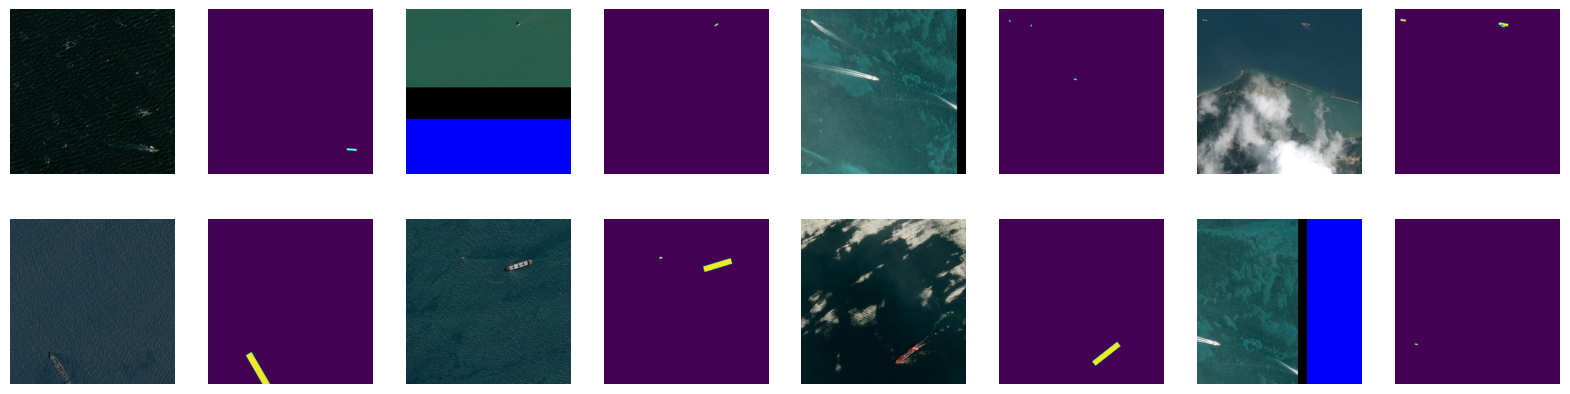

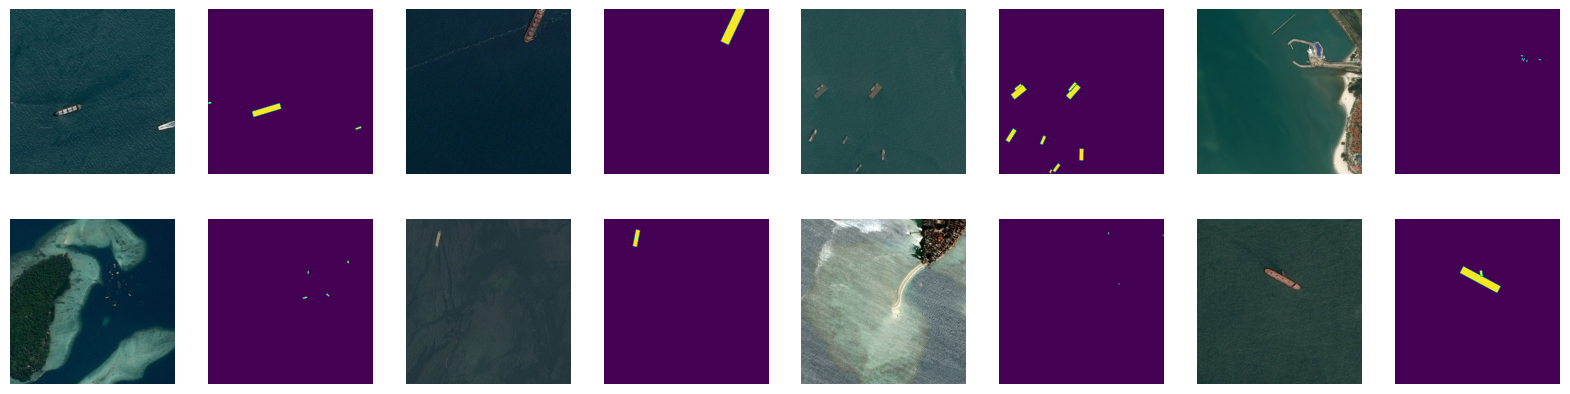

In [12]:
def draw(lista,marks_aux):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread('/content/train_v2_2/'+lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i],marks_aux)[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()

print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in images[:200] if not is_empty(i,marks)], size = 8), marks)
draw(np.random.choice([i for i in images[200:400] if not is_empty(i,marks)], size = 8), marks)
#draw(np.random.choice([i for i in images[400:600] if not is_empty(i,marks)], size = 8), marks)

In [13]:
train_fnames, test_fnames = train_test_split(images, test_size=0.2, random_state=69278)
train_fnames

array(['4790fd62c.jpg', '3a3782673.jpg', 'e9bc6f2f2.jpg', ...,
       '8d63940f9.jpg', '44b32e139.jpg', '8bc246c10.jpg'], dtype='<U13')

In [14]:
train_dpath = '/content/train_v2_2/'
test_dpath = '/content/train_v2_2/'

bst_model_fpath = '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/bst_unet.model'

original_img_size = (768, 768)


In [15]:
class param:
    img_size = (80, 80)
    bs = 32
    num_workers = 2              # num_workers, que denota el número de procesos que generan batches en paralelo
    lr = 0.001
    epochs = 5
    unet_depth = 3
    unet_start_filters = 8
    log_interval = 70 # less then len(train_dl)

channel_means = (0.20166926, 0.28220195, 0.31729624)
channel_stds = (0.20769505, 0.18813899, 0.16692209)

In [16]:
def get_mask_encodings(annos, fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()

In [17]:
get_mask_encodings(marks, train_fnames)['ef63dfa1a.jpg']

['401436 2 402204 4 402971 6 403739 6 404507 6 405275 5 406042 6 406810 6 407578 6 408346 6 409113 6 409881 6 410649 6 411417 6 412184 6 412952 6 413723 3',
 '478387 6 479155 6 479923 6 480691 6 481459 6 482227 6 482995 6 483763 6 484531 6 485299 6 486067 6 486835 6 487603 6 488371 6 489139 6',
 '500566 2 501334 4 502101 7 502869 7 503637 6 504404 7 505172 7 505939 7 506707 7 507475 6 508242 7 509010 7 509780 4 510550 2',
 '505960 4 506725 7 507493 7 508261 7 509029 7 509797 7 510565 7 511333 7 512101 7 512869 7 513638 6 514406 6 515174 6 515942 6 516710 6 517478 6 518246 6 519014 6 519782 6',
 '430699 2 431467 5 432234 8 433002 8 433770 7 434538 7 435305 8 436073 8 436841 7 437609 7 438376 8 439144 8 439912 7 440679 8 441447 8 442215 7 442983 7 443750 8 444518 8 445288 5 446059 2',
 '484452 3 485220 6 485987 7 486755 6 487523 6 488291 6 489058 6 489826 6 490594 6 491361 6 492129 6 492897 5 493664 6 494432 6 495200 5 495968 5 496735 6 497503 5 498274 2',
 '456809 5 457577 5 458345 5 45

In [18]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [19]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 mask_encodings=None,
                 mask_size=None,
                 mask_transform=None):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
        if self.img_transform is not None:
            random.seed(seed)
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if self.mask_encodings[fname][0] == self.mask_encodings[fname][0]: # NaN doesn't equal to itself
            for encoding in self.mask_encodings[fname]:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask)

        random.seed(seed)
        mask = self.mask_transform(mask)
        return img, torch.from_numpy(np.array(mask, dtype=np.int64))

    def __len__(self):
        return len(self.img_fnames)

In [20]:
train_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(channel_means, channel_stds)])
test_tfms = transforms.Compose([transforms.Resize(param.img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

train_dl = DataLoader(ImgDataset(train_dpath,
                                 train_fnames,
                                 train_tfms,
                                 get_mask_encodings(marks, train_fnames),
                                 original_img_size,
                                 mask_tfms),
                      batch_size=param.bs,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)



test_dl = DataLoader(ImgDataset(test_dpath,
                                test_fnames,
                                test_tfms),
                     batch_size=param.bs,
                     shuffle=False,
                     pin_memory=torch.cuda.is_available(),
                     num_workers=param.num_workers)


torch.Size([32, 3, 80, 80])
torch.Size([32, 80, 80])
tensor([[[[-6.5000e-01, -4.8007e-01, -5.3672e-01,  ..., -2.7238e-01,
           -4.4231e-01, -1.9685e-01],
          [-6.5000e-01, -6.8777e-01, -5.7448e-01,  ..., -2.9126e-01,
           -4.4231e-01, -4.6119e-01],
          [-6.8777e-01, -5.1783e-01, -6.3112e-01,  ..., -4.2343e-01,
           -4.2343e-01, -3.2902e-01],
          ...,
          [-7.0665e-01, -5.5560e-01, -5.5560e-01,  ...,  1.8078e-01,
            2.5630e-01,  3.8847e-01],
          [-7.2553e-01, -7.2553e-01, -6.5000e-01,  ...,  3.5071e-01,
            5.3952e-01,  3.3183e-01],
          [-7.2553e-01, -4.6119e-01, -5.3672e-01,  ...,  1.2413e-01,
            8.6051e-01,  5.9617e-01]],

         [[-2.0041e-02,  2.7177e-01,  1.0502e-01,  ...,  2.1647e-02,
            8.0264e-04,  3.7599e-01],
          [ 1.8840e-01,  8.4179e-02,  8.0264e-04,  ...,  1.0502e-01,
            8.4179e-02,  1.4671e-01],
          [ 8.4179e-02,  2.0924e-01,  8.0264e-04,  ...,  2.7177e-01,
     

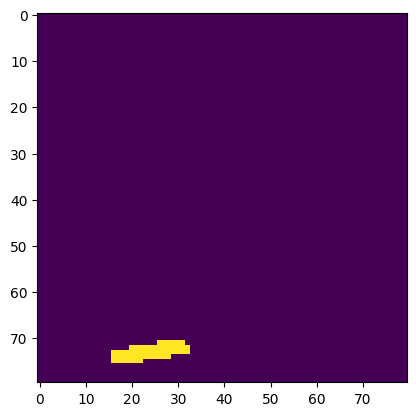

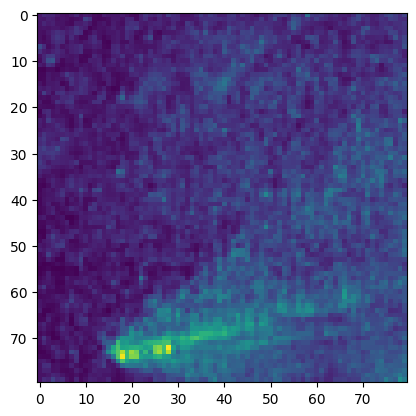

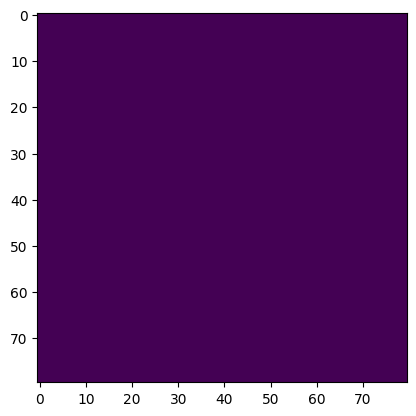

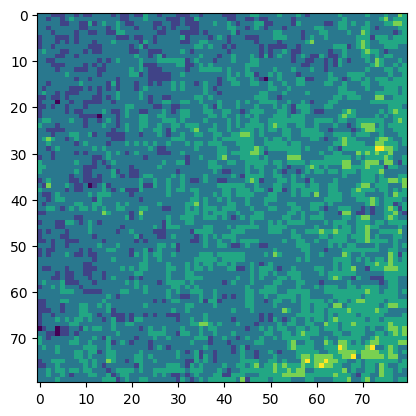

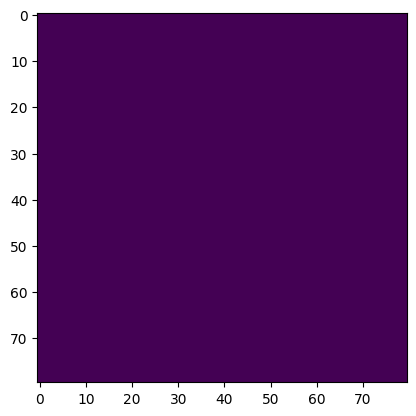

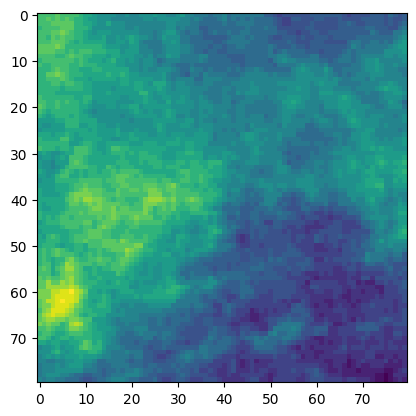

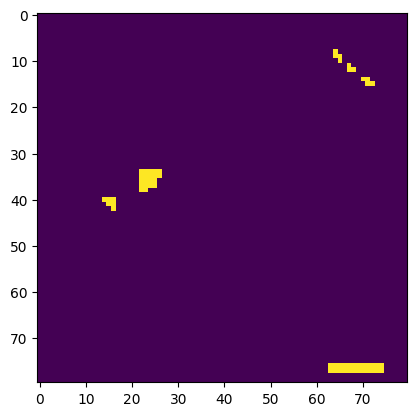

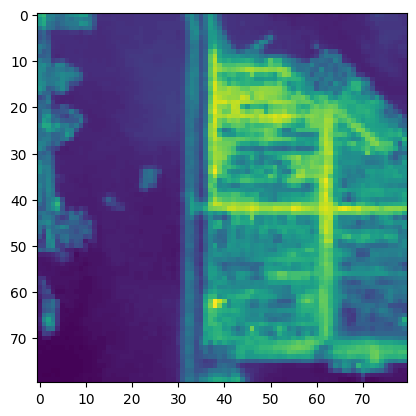

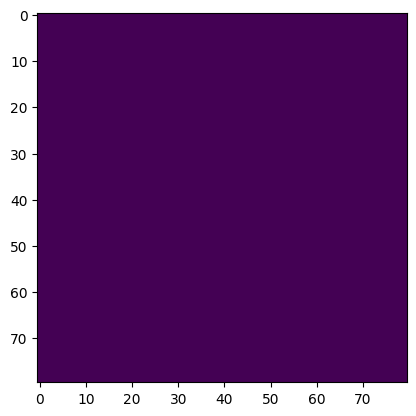

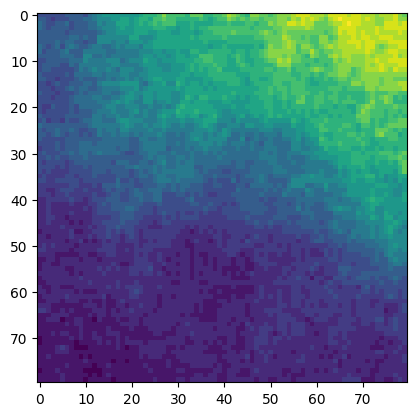

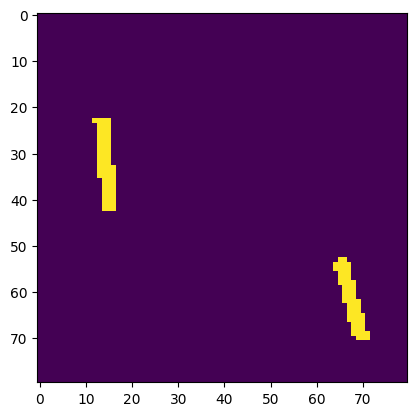

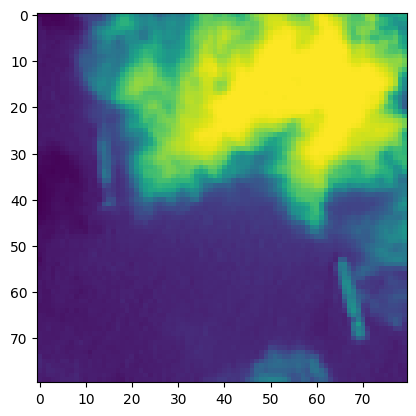

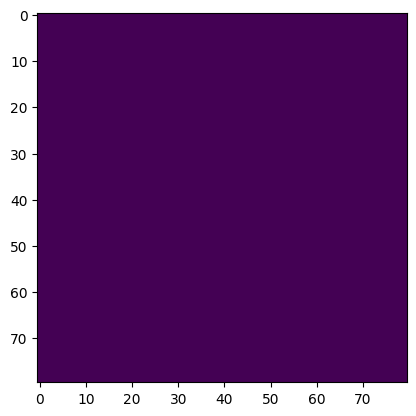

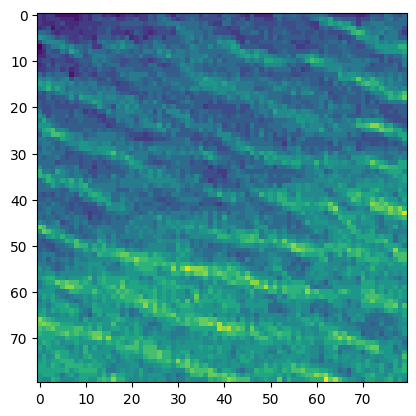

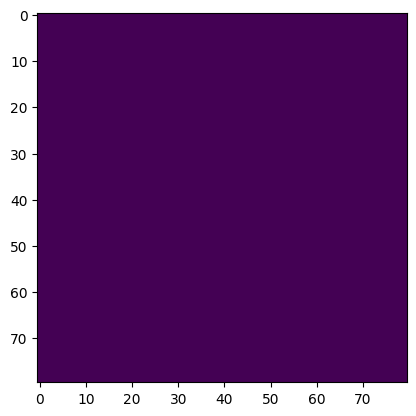

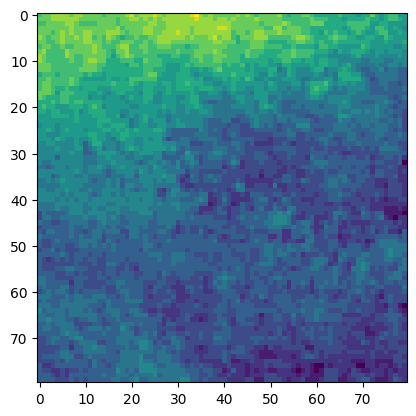

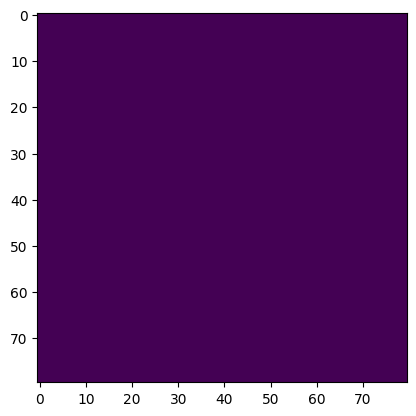

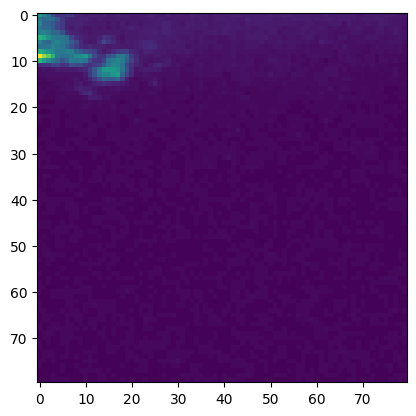

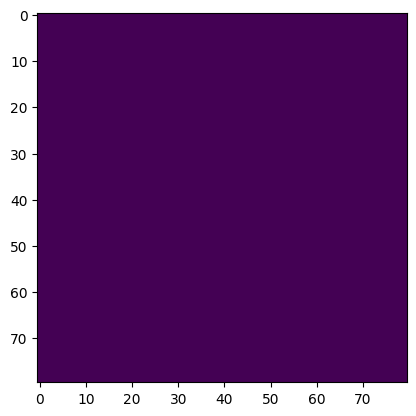

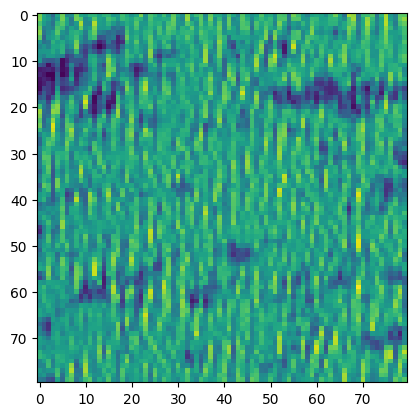

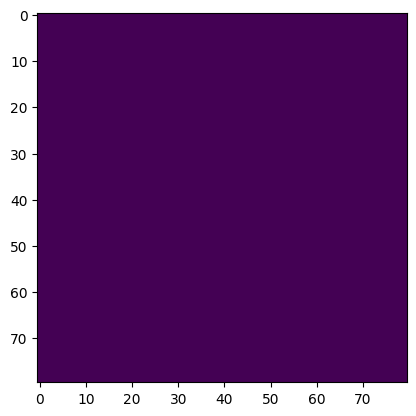

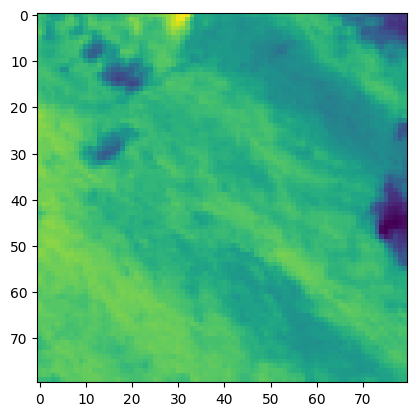

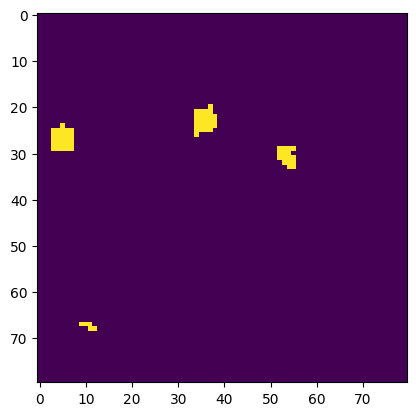

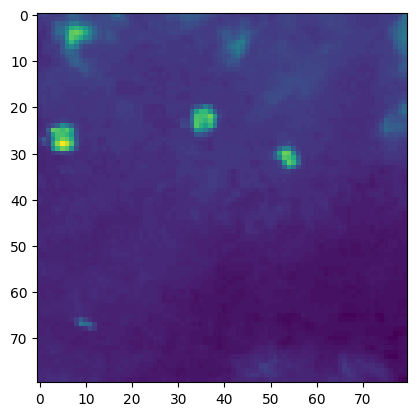

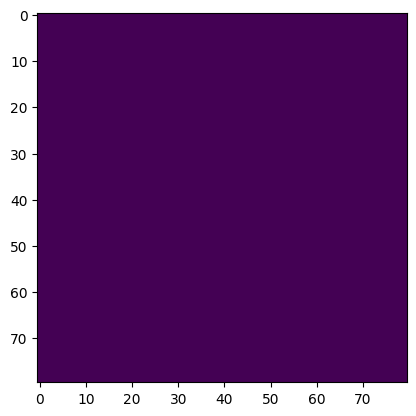

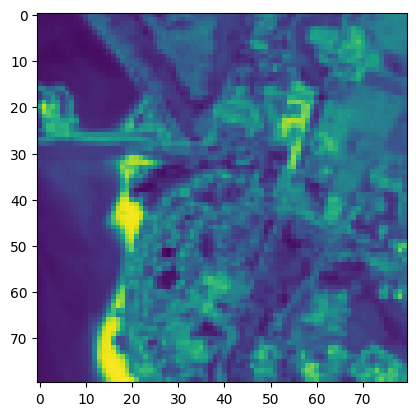

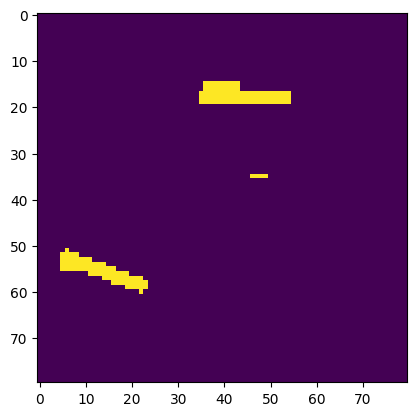

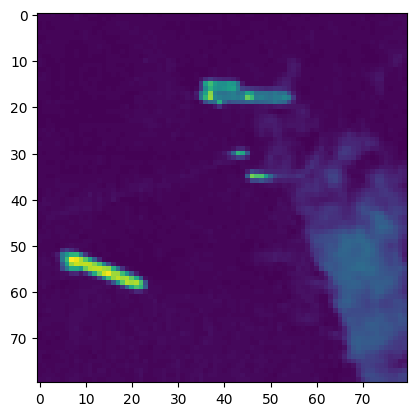

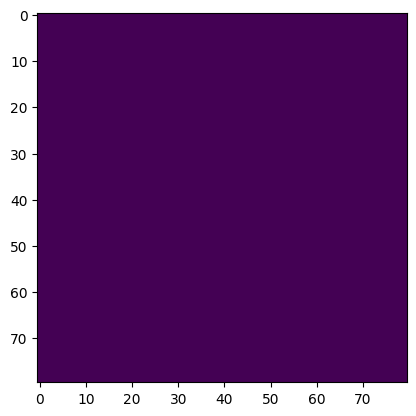

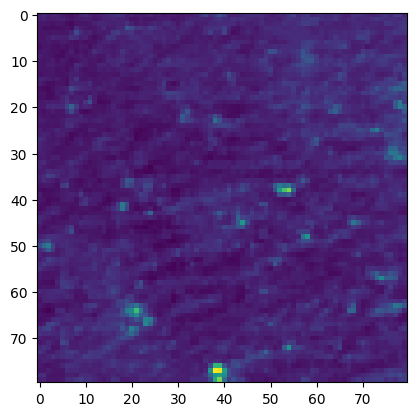

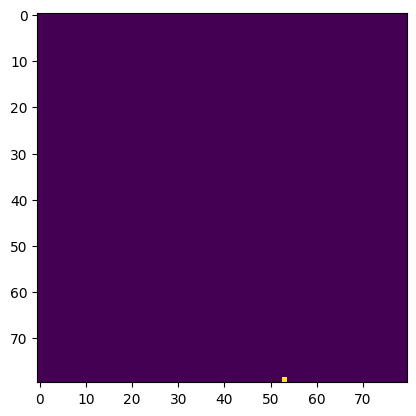

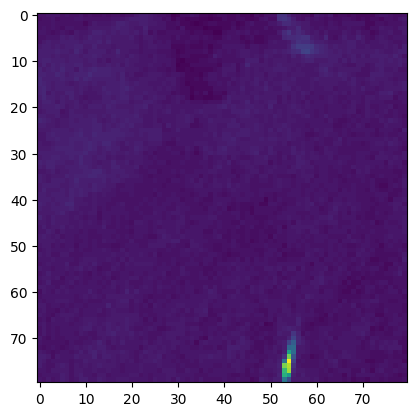

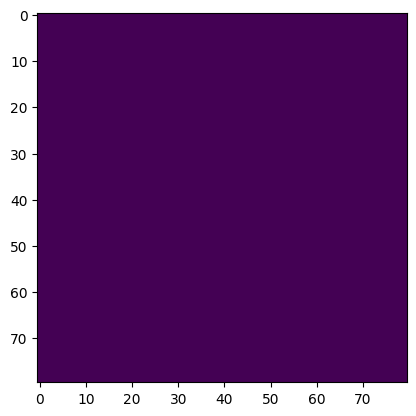

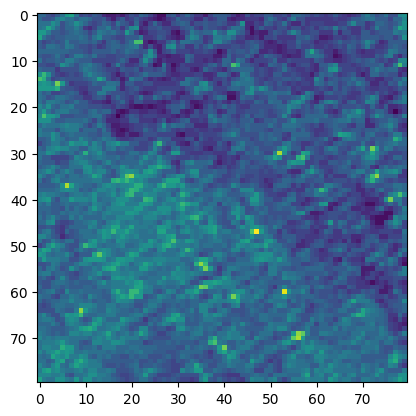

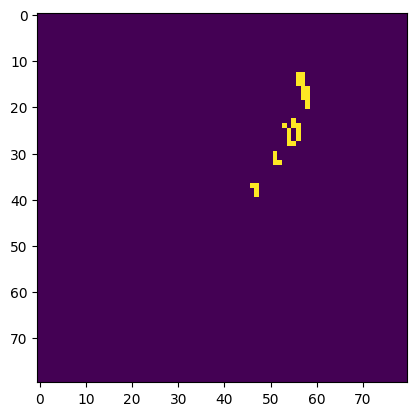

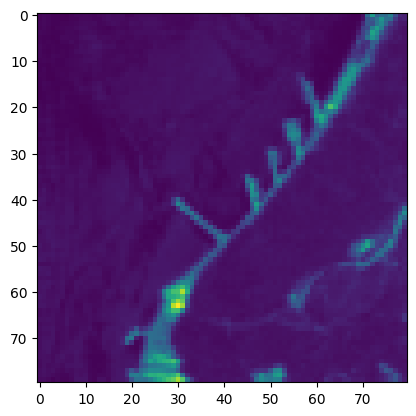

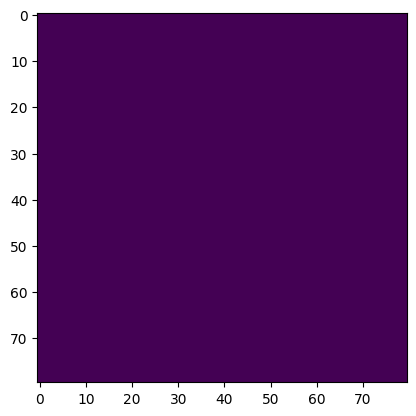

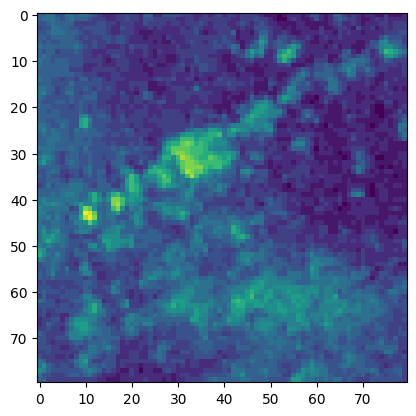

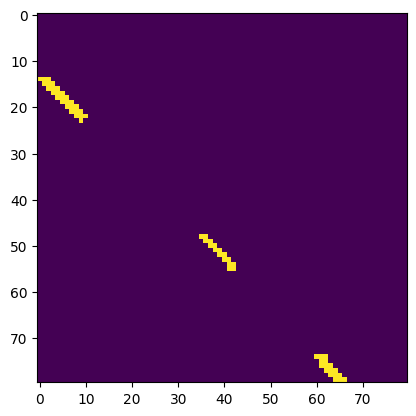

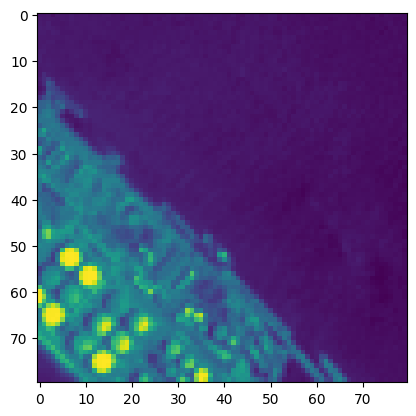

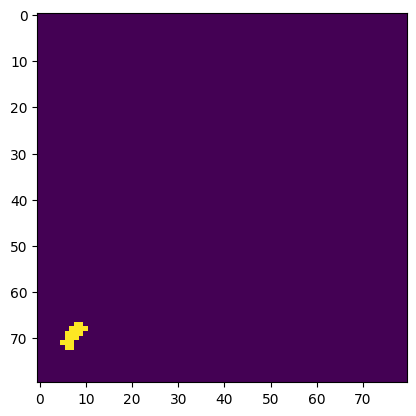

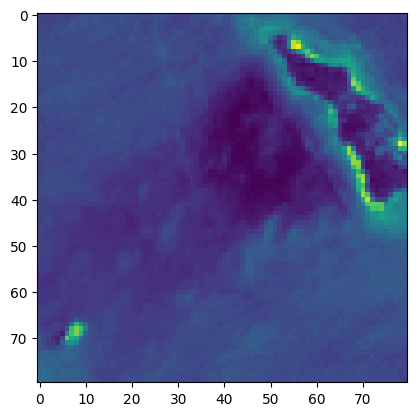

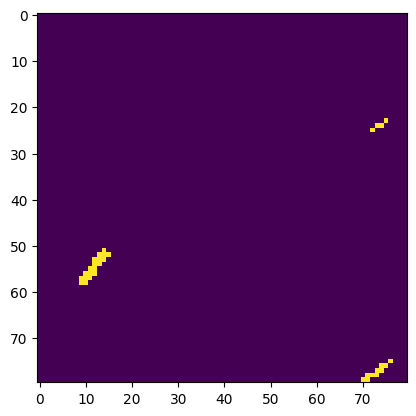

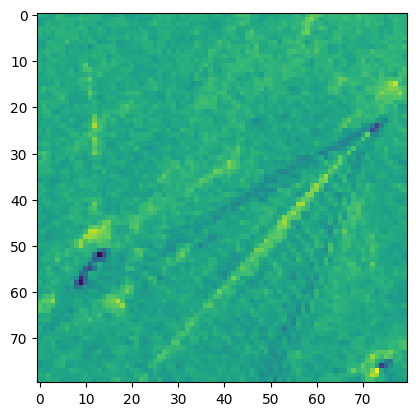

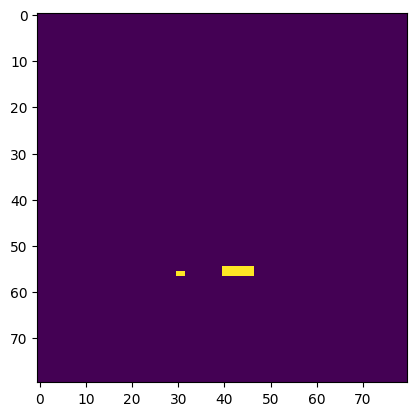

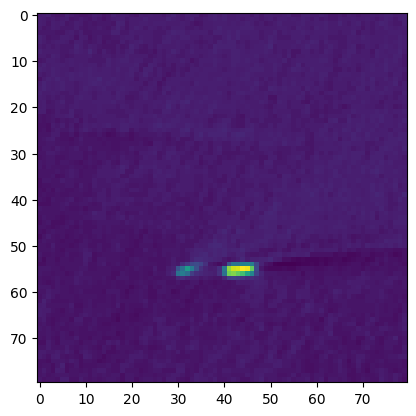

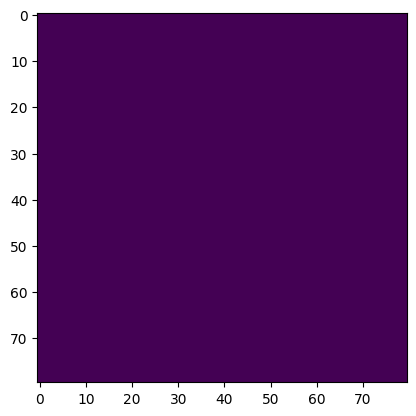

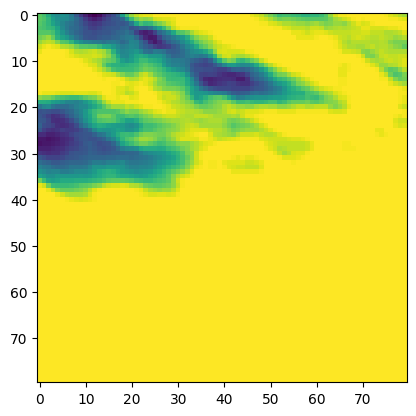

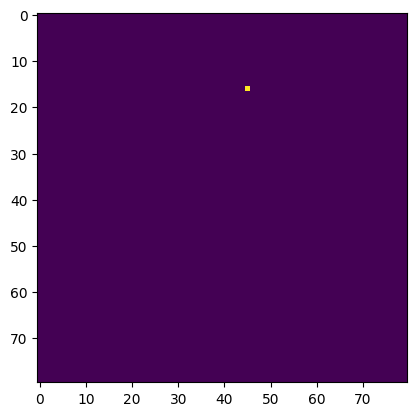

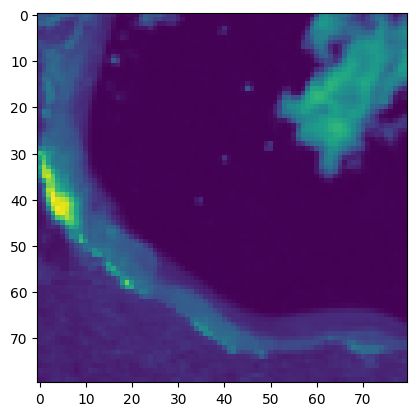

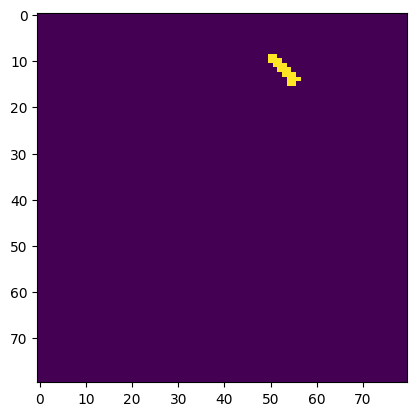

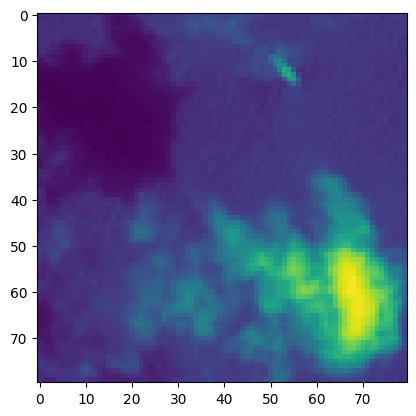

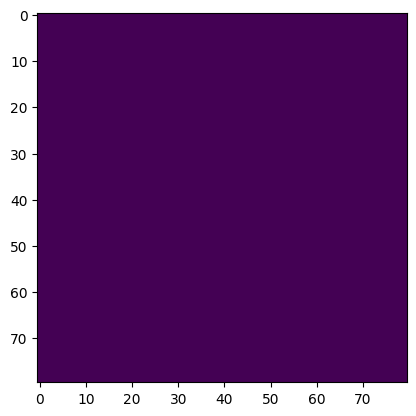

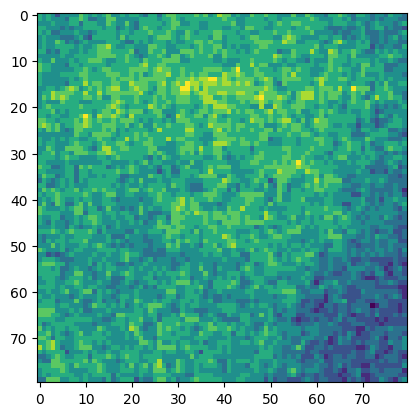

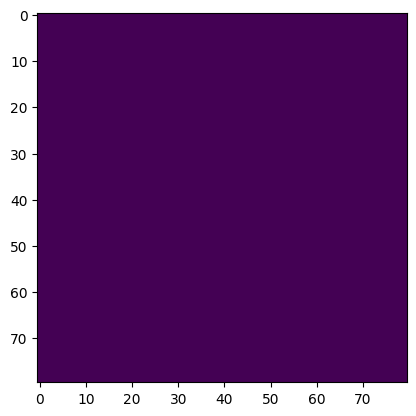

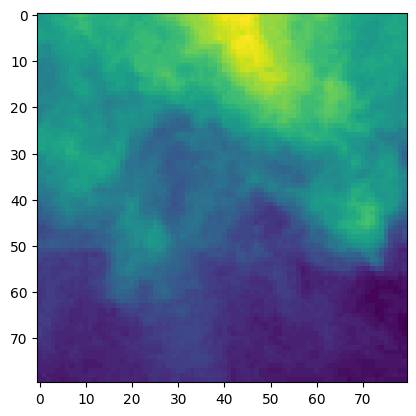

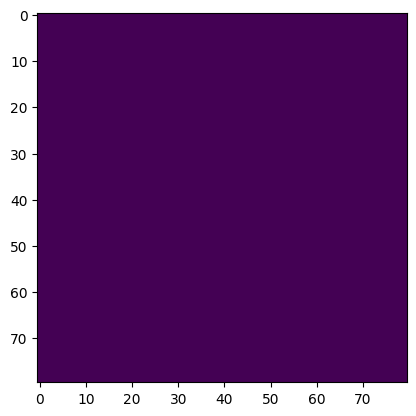

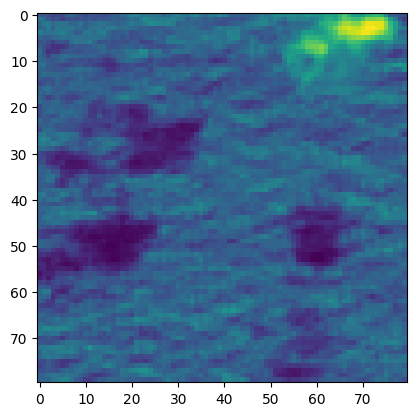

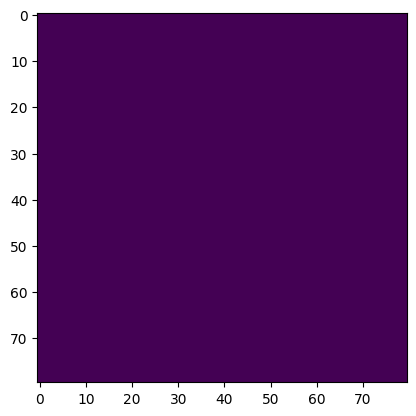

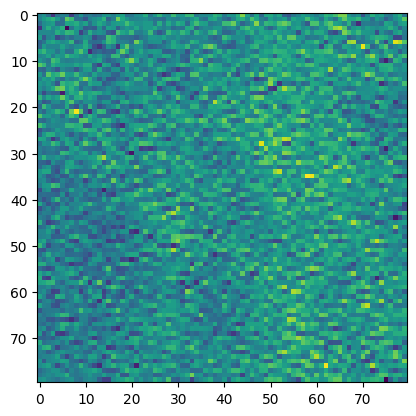

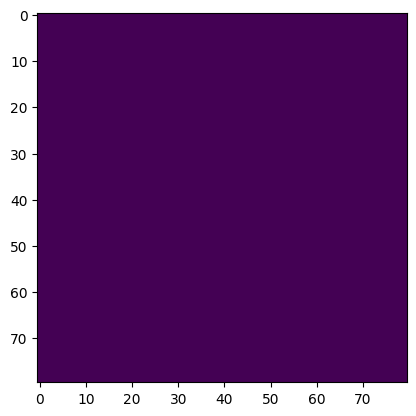

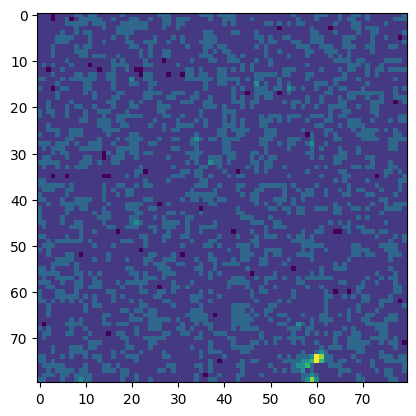

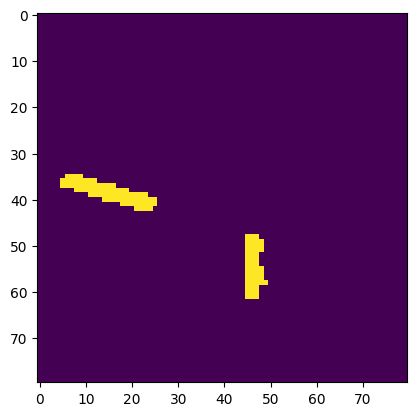

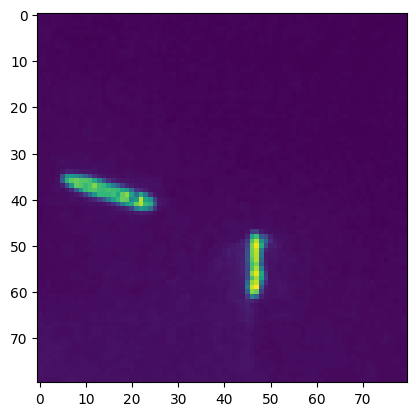

In [23]:
for img, mask in train_dl:
  print(img.shape)
  print(mask.shape)
  print(img)
  print(mask)
  for i in range(param.bs):
    a = mask[i].cpu().numpy()
    #first_channel = a[0,:, :]
    plt.imshow(a)
    plt.show()
    b = img[i].cpu().numpy()
    first_channel = b[0,:, :]
    plt.imshow(first_channel)
    plt.show()
  break

In [24]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)
    
def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [25]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)
        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [26]:
class UNet(nn.Module):

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
  
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))
            
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)


        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = torch.sigmoid(self.conv_final(x))
        return x

In [26]:
model = UNet(1,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').cuda()   #Descomentar #.cuda() si hay GPU disponibles  
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

In [27]:
model.eval()

UNet(
  (conv_final): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up_convs): ModuleList(
    (0): UpConv(
      (upconv): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
      (conv1): Conv2d(32, 16, kernel_size=(3, 

In [28]:
iters = []
train_losses = []

it = 0

os.makedirs(os.path.dirname(bst_model_fpath), exist_ok=True)

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_dl):
        X = X.cuda()
        y = y.cuda()
        outputs = model(X)  # [N, 1, H, W]

        #loss = F.cross_entropy(outputs, y)
        loss = nn.BCELoss()(outputs.reshape(outputs.shape[0], 80,80), y.to(torch.float32))

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            train_losses.append(loss.item())

            model.eval()
            model.train()

    print('| Epoch: %d | Loss: %.4f |' \
          %(epoch, loss.item()))        

#model.eval()
torch.save(model.state_dict(), bst_model_fpath)

| Epoch: 0 | Loss: 0.0594 |
| Epoch: 1 | Loss: 0.0008 |
| Epoch: 2 | Loss: 0.0182 |
| Epoch: 3 | Loss: 0.0042 |
| Epoch: 4 | Loss: 0.0027 |


In [32]:
the_model = UNet(1,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat')#.cuda()   #Descomentar si hay GPU disponibles 
the_model.load_state_dict(torch.load(bst_model_fpath, map_location=torch.device('cpu'))) #Quitar map_location=torch.device('cpu') si hay GPU disponibles
#the_model.eval() 

<All keys matched successfully>

Predicciones

In [126]:
submission = {'ImageId': [], 'EncodedPixels': []}
from skimage.morphology import binary_opening, disk, label

#model.eval()
for X, fnames in test_dl:
    X = X#.cuda()
    output = the_model(X)
    for i, fname in enumerate(fnames):
        mask = output[i,0].data.cpu().numpy()
        mask = (mask>0.2)
        mask = Image.fromarray(mask.astype(np.uint8)).resize(original_img_size)
        mask = np.array(mask).astype(bool)

        labels = label(mask)
        encodings = [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]
        if len(encodings) > 0:
          for j in range(len(encodings)):
               submission['ImageId'].append(fname)
               submission['EncodedPixels'].append(encodings[j])
        else:
            submission['ImageId'].append(fname)
            submission['EncodedPixels'].append(None)

In [122]:
submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels'])
#submission_df.to_csv('submission.csv', index=False)
submission_df

,ImageId,EncodedPixels
0,22555f286.jpg,96681 11 97449 11 98217 11 98985 11 99753 11 1...
1,54b9aff5f.jpg,None
2,a4360f670.jpg,155482 28 156250 28 157018 28 157786 28 158554...
3,661ac4d1e.jpg,None
4,80f5beee0.jpg,None
...,...,...
6437,558b65c7b.jpg,287472 19 288240 19 289008 19 289776 19 290544...
6438,558b65c7b.jpg,339101 29 339869 29 340637 29 341405 29 342173...
6439,558b65c7b.jpg,353731 19 354499 19 355267 19 356035 19 356803...
6440,558b65c7b.jpg,376828 11 377596 11 378364 11 379132 11 379900...


Randomly chosen images with corresponding masks


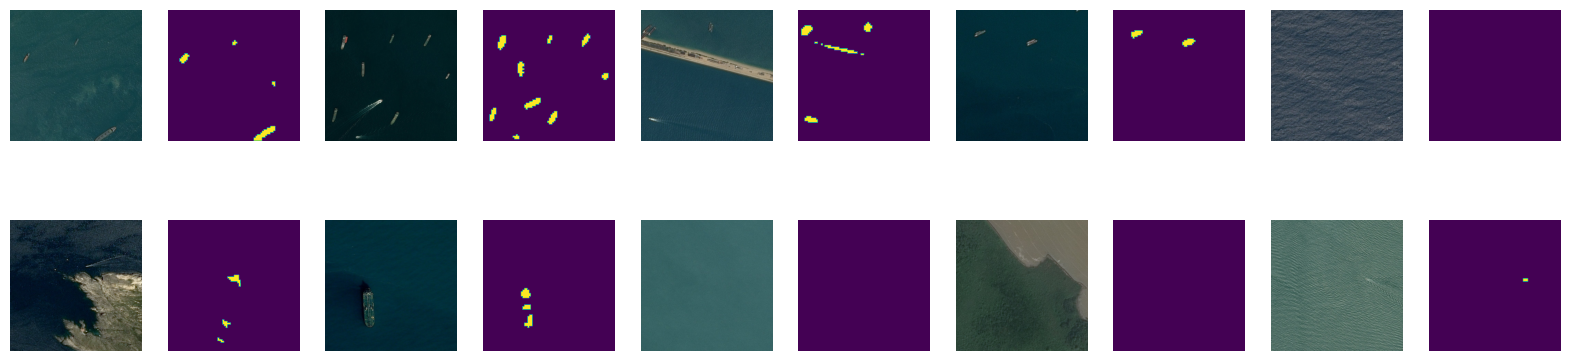

In [123]:
print('Randomly chosen images with corresponding masks')
j = 1
draw([i for i in test_fnames[10*j:10*j+10]], submission_df)